In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150

In [2]:
import time
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import ks_2samp
from scipy.special import factorial

In [3]:
from exopop import Simulator, data, abcmodel

In [4]:
NMAX = 20
PERIOD_RNG = (5, 300.)
RADIUS_RNG = (0.5, 12.)
MESTHRESH = 15.0

# Get the datasets.
stlr = data.get_burke_gk().iloc[:1000]
kois = data.get_candidates(stlr, period_range=PERIOD_RNG, radius_range=RADIUS_RNG, mesthresh=MESTHRESH)
dataset = abcmodel.RealDataset(stlr, kois, NMAX)

print("Selected {0} targets after cuts".format(len(stlr)))
print("Selected {0} KOIs after cuts".format(len(kois)))
print("Observed multiplicity distribution: {0}".format(dataset.multiplicity))

Selected 1000 targets after cuts
Selected 10 KOIs after cuts
Observed multiplicity distribution: [991   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


[  0.01624911   0.66919793  14.43443575  -0.6131299 ]


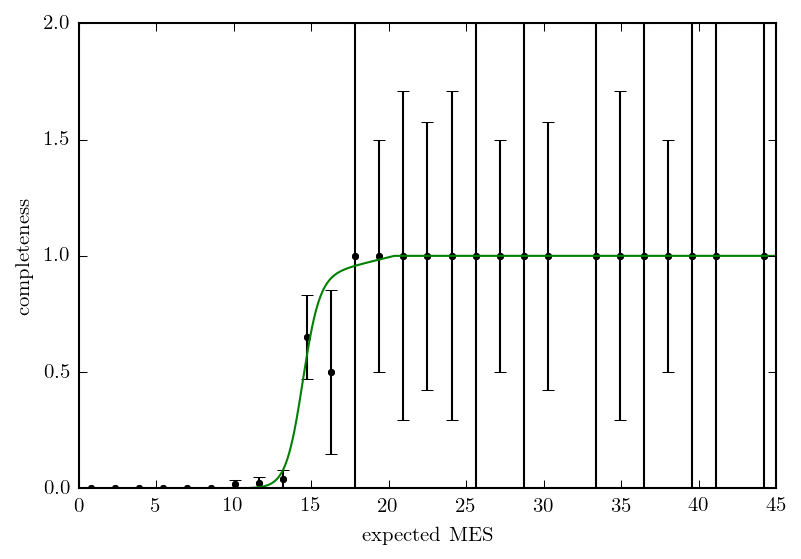

In [5]:
params, _ = data.calibrate_completeness(stlr, period_range=PERIOD_RNG, plot=True)
print(params)

In [6]:
strt = time.time()
sim = Simulator(stlr, NMAX, RADIUS_RNG[0], RADIUS_RNG[1],
                PERIOD_RNG[0], PERIOD_RNG[1], params)
print("Simulator setup took {0} seconds".format(time.time() - strt))

Simulator setup took 1.65547513961792 seconds


In [7]:
pars = np.array([
    -2.2, np.log(3.0),     # multiplicity
    -2.0, -4, 3.0,         # radius
    0.1, -0.65, 13.0,      # period
    np.log(1.0)            # inclination
])

model = abcmodel.ExopopABCModel(sim, dataset, pars)

In [16]:
sim_data = model.get_simulated_dataset()
sim_model = abcmodel.ExopopABCModel(sim, sim_data, pars, thawed_parameters=[0, 1, -1])

In [20]:
sim_model.negative_log_distance()

-9.1849297661509688

In [21]:
chain, nlds = sim_model.sample(sim_model.theta, 1000, nld_thresh=-10.0)

(array([ 245.,  140.,   20.,   61.,   80.,   77.,  105.,   17.,  152.,  103.]),
 array([-9.99491907, -9.87060088, -9.7462827 , -9.62196451, -9.49764632,
        -9.37332814, -9.24900995, -9.12469176, -9.00037358, -8.87605539,
        -8.7517372 ]),
 <a list of 10 Patch objects>)

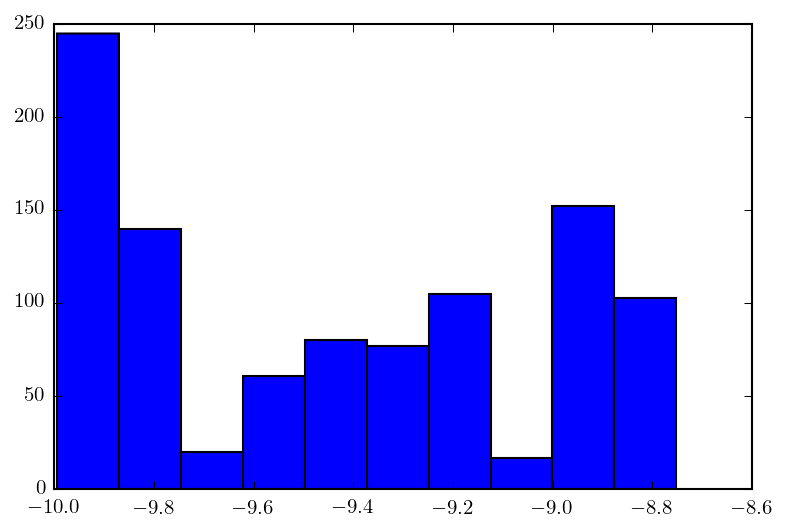

In [22]:
pl.hist(nlds)

In [ ]:
sim_model.plot(nsamps=10);